In [1]:
import torch, torchvision, tqdm, os
import matplotlib.pyplot as plt
import albumentations as A
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

from PIL import Image
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [7]:
# https://www.kaggle.com/datasets/vasukipatel/face-recognition-dataset
data = pd.read_csv("data/Dataset.csv")
data.head()

,id,label
0,Robert Downey Jr_87.jpg,Robert Downey Jr
1,Lisa Kudrow_64.jpg,Lisa Kudrow
2,Ellen Degeneres_34.jpg,Ellen Degeneres
3,Billie Eilish_3.jpg,Billie Eilish
4,Hrithik Roshan_35.jpg,Hrithik Roshan


In [8]:
identities = data['label'].unique()
identities

array(['Robert Downey Jr', 'Lisa Kudrow', 'Ellen Degeneres',
       'Billie Eilish', 'Hrithik Roshan', 'Vijay Deverakonda',
       'Tom Cruise', 'Alia Bhatt', 'Elizabeth Olsen', 'Charlize Theron',
       'Natalie Portman', 'Priyanka Chopra', 'Zac Efron', 'Marmik',
       'Camila Cabello', 'Claire Holt', 'Brad Pitt', 'Anushka Sharma',
       'Roger Federer', 'Akshay Kumar', 'Alexandra Daddario',
       'Hugh Jackman', 'Andy Samberg', 'Margot Robbie', 'Courtney Cox',
       'Dwayne Johnson', 'Amitabh Bachchan', 'Henry Cavill',
       'Virat Kohli', 'Jessica Alba', 'Kashyap'], dtype=object)

In [9]:
len(identities)

31

In [10]:
# Encoder of the identities
encoder = {val:key for key, val in enumerate(identities)}

In [6]:
img_path = "data/Faces/Faces/"
len(os.listdir(img_path))

2562

In [7]:
image_w, image_h, mean_r, mean_g, mean_b, std_r, std_g, std_b = [], [], [], [], [], [], [], []


for image in tqdm.tqdm(data.id):
    image  = Image.open(img_path + image).convert("RGB")
    image = np.array(image)
    
    # image heigth and widths
    width, height, c = image.shape
    image_w.append(width)
    image_h.append(height)

    # image means
    r = image[:, :, 0]
    g = image[:, :, 1]
    b = image[:, :, 2]
    
    mean_r.append(r.mean())
    mean_g.append(r.mean())
    mean_b.append(r.mean())
    
    # image stds 
    std_r.append(r.std())
    std_g.append(g.std())
    std_b.append(b.std())
    

100%|████████████████████████████████████████████████████████████████████████████| 2562/2562 [00:01<00:00, 1348.83it/s]


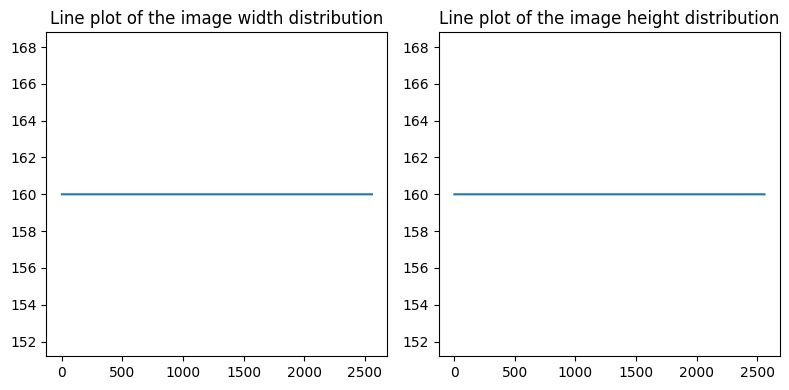

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].plot(image_w)
axs[0].set_title("Line plot of the image width distribution")

axs[1].plot(image_h)
axs[1].set_title("Line plot of the image height distribution")

# Adjust layout to prevent clipping of titles
plt.tight_layout()


plt.show()

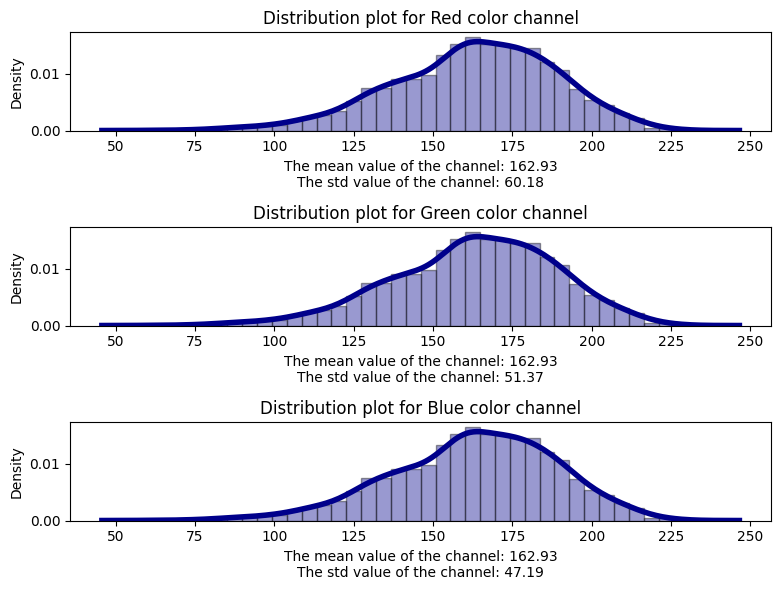

In [9]:
import warnings

# Ignore all UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)


fig, axs = plt.subplots(3, 1, figsize=(8, 6))


sns.distplot(mean_r, hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axs[0])
axs[0].set_title("Distribution plot for Red color channel")
axs[0].set_xlabel(f"The mean value of the channel: {np.mean(mean_r):.2f}\nThe std value of the channel: {np.mean(std_r):.2f}")

sns.distplot(mean_r, hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},  ax=axs[1])
axs[1].set_title("Distribution plot for Green color channel")
axs[1].set_xlabel(f"The mean value of the channel: {np.mean(mean_g):.2f}\nThe std value of the channel: {np.mean(std_g):.2f}")

sns.distplot(mean_r, hist=True, kde=True,
             bins=int(180/5), color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax=axs[2])
axs[2].set_title("Distribution plot for Blue color channel")
axs[2].set_xlabel(f"The mean value of the channel: {np.mean(mean_b):.2f}\nThe std value of the channel: {np.mean(std_b):.2f}")

# Adjust layout to prevent clipping of titles
plt.tight_layout()

plt.show()

In [10]:
means = np.array([np.mean(mean_r), np.mean(mean_g), np.mean(mean_b)]) / 255.
means

array([0.63894559, 0.63894559, 0.63894559])

In [11]:
stds = np.array([np.mean(std_r), np.mean(std_g), np.mean(std_b)]) / 255.
stds

array([0.23599487, 0.20144476, 0.18505558])

# Image Augmentation

In [12]:
transformer = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=[0.63894559, 0.63894559, 0.63894559], std=[0.23599487, 0.20144476, 0.18505558]),
    A.OneOf([
        A.MotionBlur(p=.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0525, scale_limit=0.1, rotate_limit=1, p=1),
    A.GridDistortion(p=.2, border_mode=1),
    A.OneOf([
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(p=0.2),
    ]),
    ToTensorV2(),
])

val_transformer = A.Compose([
    A.Resize(width=224, height=224),
    A.Normalize(mean=[0.63894559, 0.63894559, 0.63894559], std=[0.23599487, 0.20144476, 0.18505558]),
    ToTensorV2(),
])

C:\Users\yerda\AppData\Roaming\Python\Python311\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
C:\Users\yerda\AppData\Roaming\Python\Python311\site-packages\albumentations\imgaug\transforms.py:174: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


# Dataset class

In [13]:
# Dataset split
train, test = train_test_split(data, test_size=0.2, random_state=1)

train = train.reset_index(drop=True)
test = test.reset_index(drop=True);

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

In [14]:
class dataset(Dataset):
    def __init__(self, df, encoder, transformer, path="data/Faces/Faces/"):
        super(dataset, self).__init__()
        self.df = df
        self.img_path = path
        self.encoder = encoder
        self.transformer = transformer
    
    def __len__(self,):
        return len(self.df)
    
    def __getitem__(self, x):
        image = self.df.at[x, "id"]
        image = Image.open(self.img_path+image).convert("RGB")
        image = np.array(image)
        image = self.transformer(image=image)['image']
        
        label = self.df.at[x, "label"]
        label = self.encoder[label]
        label = torch.tensor(label)
        
        return image, label

In [15]:
trainLoader = DataLoader(dataset(train, encoder, transformer), batch_size=64, shuffle=True)
testLoader = DataLoader(dataset(test, encoder, val_transformer), batch_size=64, shuffle=False)

In [16]:
image, i = next(iter(trainLoader))
image.shape

torch.Size([64, 3, 224, 224])

# Model

In [17]:
from torchvision.models import resnet18

# Load pre-trained ResNet-18 model
model = resnet18(pretrained=True)

In [18]:
# modify the last layer
model.fc = torch.nn.Linear(in_features=512, out_features=256, bias=True)

In [19]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=31):
        super(ResNet18, self).__init__()
        self.resnet18 = resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(in_features=512, out_features=256, bias=True)
        self.out = nn.Linear(in_features=256, out_features=num_classes, bias=False)
        
    def forward(self, x):
        x = self.resnet18(x)
        return x, self.out(x)

In [20]:
model = ResNet18()

In [21]:
from torchsummary import summary

In [22]:
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [23]:
class center_loss(nn.Module):
    def __init__(self, lambdas=0.01, num_classes=10, feature_dim=256):
        super(center_loss, self).__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feature_dim))
        self.entropy_loss = nn.CrossEntropyLoss()
        self.lambdas = lambdas
        
        
    def forward(self, features, output, labels):
        cls_centers = self.centers.index_select(dim=0, index=labels)
        
        Lc = torch.pow(features - cls_centers, 2).sum() * 0.5
        # assert len(cls_centers) == len(featrues), f"They are not equal | {len(cls_centers)} | {len(features)}"
        La = self.entropy_loss(output, labels)
        
        return La + self.lambdas * Lc

# Train

In [24]:
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = center_loss(num_classes=len(identities), ).to(device)

In [25]:
def save_model(model_name, epoch, prev_loss, current_loss, model, optimizer):
    if prev_loss > current_loss:
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/best_{model_name}.pt") # create models folder before! 
        print("The best model was saved!")
        prev_loss = current_loss
    
    torch.save({
            "epoch": epoch,
            "modelsz": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": current_loss,
        }, f"models/last_{model_name}.pt")
    return prev_loss


os.makedirs("models", exist_ok=True)

num_epochs, prev_loss = 100, torch.inf
train_loss, val_loss = [], []

In [26]:
train_loss, val_loss = [], []


for epoch in tqdm.trange(num_epochs):
    model.train()
    loss_list, count, FE_train = 0, 0, []
    for images, targets in trainLoader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        
        features, output = model(images)
        
        loss = criterion(features, output, targets)
        loss.backward()
        optimizer.step()
        loss_list += loss.item()
        count += 1
    loss = loss_list/count
    train_loss.append(loss)
    model.eval()
    @torch.no_grad()
    def validation():
        val_loss, val_counter, FE_VAL = 0, 0, []
        for images, targets in testLoader:
            images = images.to(device)
            targets = targets.to(device)
            
            features, output = model(images)
            loss = criterion(features, output, targets)
            val_loss += loss.item()
            val_counter += 1
        return val_loss / val_counter
    v_loss = validation()
    val_loss.append(v_loss)
    
    prev_loss = save_model("resnet18", epoch, prev_loss, v_loss, model, optimizer)
    print(f"Epoch: {epoch} | Training loss {loss} | Validation loss {v_loss}")

  1%|▊                                                                                 | 1/100 [00:16<26:24, 16.01s/it]

The best model was saved!
Epoch: 0 | Training loss 73.17447286663634 | Validation loss 66.977349864112


  2%|█▋                                                                                | 2/100 [00:27<21:33, 13.20s/it]

The best model was saved!
Epoch: 1 | Training loss 45.63422360564723 | Validation loss 53.454807652367485


  3%|██▍                                                                               | 3/100 [00:37<19:29, 12.05s/it]

The best model was saved!
Epoch: 2 | Training loss 28.052792520234078 | Validation loss 28.04510533147388


  4%|███▎                                                                              | 4/100 [00:48<18:16, 11.42s/it]

Epoch: 3 | Training loss 18.184740189350013 | Validation loss 30.613249328401352


  5%|████                                                                              | 5/100 [00:58<17:34, 11.10s/it]

The best model was saved!
Epoch: 4 | Training loss 15.242420254331646 | Validation loss 21.044287350442673


  6%|████▉                                                                             | 6/100 [01:09<17:06, 10.92s/it]

The best model was saved!
Epoch: 5 | Training loss 11.005689895514285 | Validation loss 12.317581317491001


  7%|█████▋                                                                            | 7/100 [01:19<16:42, 10.78s/it]

Epoch: 6 | Training loss 9.370403130849203 | Validation loss 13.420163361562622


  8%|██████▌                                                                           | 8/100 [01:30<16:30, 10.76s/it]

The best model was saved!
Epoch: 7 | Training loss 8.492139975229898 | Validation loss 10.997653266415


  9%|███████▍                                                                          | 9/100 [01:41<16:10, 10.66s/it]

Epoch: 8 | Training loss 7.518899715307987 | Validation loss 12.379653624776337


 10%|████████                                                                         | 10/100 [01:51<15:57, 10.63s/it]

The best model was saved!
Epoch: 9 | Training loss 6.129040638605754 | Validation loss 8.280797908703486


 11%|████████▉                                                                        | 11/100 [02:02<15:43, 10.61s/it]

Epoch: 10 | Training loss 5.672750010634914 | Validation loss 9.03205238406857


 12%|█████████▋                                                                       | 12/100 [02:12<15:33, 10.61s/it]

The best model was saved!
Epoch: 11 | Training loss 5.512926376227177 | Validation loss 7.779880479806


 13%|██████████▌                                                                      | 13/100 [02:23<15:22, 10.60s/it]

Epoch: 12 | Training loss 5.779577240799412 | Validation loss 9.540000556657711


 14%|███████████▎                                                                     | 14/100 [02:34<15:12, 10.61s/it]

The best model was saved!
Epoch: 13 | Training loss 4.865733869148023 | Validation loss 7.562730886042118


 15%|████████████▏                                                                    | 15/100 [02:44<15:01, 10.61s/it]

The best model was saved!
Epoch: 14 | Training loss 5.162286621151549 | Validation loss 7.159562729506029


 16%|████████████▉                                                                    | 16/100 [02:55<14:45, 10.55s/it]

Epoch: 15 | Training loss 5.268991275267168 | Validation loss 12.497116192140513


 17%|█████████████▊                                                                   | 17/100 [03:05<14:39, 10.59s/it]

Epoch: 16 | Training loss 5.045882470680006 | Validation loss 8.229351570415828


 18%|██████████████▌                                                                  | 18/100 [03:16<14:31, 10.63s/it]

Epoch: 17 | Training loss 4.513191093098033 | Validation loss 7.88490750392278


 19%|███████████████▍                                                                 | 19/100 [03:27<14:19, 10.61s/it]

Epoch: 18 | Training loss 4.486870635639537 | Validation loss 8.07083330510391


 20%|████████████████▏                                                                | 20/100 [03:37<14:07, 10.60s/it]

Epoch: 19 | Training loss 4.683731324744947 | Validation loss 9.888934422905246


 21%|█████████████████                                                                | 21/100 [03:47<13:51, 10.53s/it]

Epoch: 20 | Training loss 4.511997121753114 | Validation loss 7.600404356088903


 22%|█████████████████▊                                                               | 22/100 [03:58<13:44, 10.57s/it]

The best model was saved!
Epoch: 21 | Training loss 3.9163222963159736 | Validation loss 6.063162336953813


 23%|██████████████████▋                                                              | 23/100 [04:09<13:34, 10.58s/it]

The best model was saved!
Epoch: 22 | Training loss 3.9875845475630327 | Validation loss 5.537683903964029


 24%|███████████████████▍                                                             | 24/100 [04:19<13:24, 10.58s/it]

Epoch: 23 | Training loss 3.403056274760853 | Validation loss 5.9624962849128575


 25%|████████████████████▎                                                            | 25/100 [04:30<13:11, 10.56s/it]

Epoch: 24 | Training loss 3.063482176173817 | Validation loss 6.38907930875818


 26%|█████████████████████                                                            | 26/100 [04:41<13:04, 10.60s/it]

Epoch: 25 | Training loss 3.732012394702796 | Validation loss 6.008924073850115


 27%|█████████████████████▊                                                           | 27/100 [04:51<12:54, 10.62s/it]

Epoch: 26 | Training loss 3.5367407871015146 | Validation loss 6.046835701084799


 28%|██████████████████████▋                                                          | 28/100 [05:02<12:39, 10.54s/it]

Epoch: 27 | Training loss 3.296608390230121 | Validation loss 6.325571111920807


 29%|███████████████████████▍                                                         | 29/100 [05:12<12:29, 10.55s/it]

The best model was saved!
Epoch: 28 | Training loss 3.8592298247597436 | Validation loss 5.4025577549926105


 30%|████████████████████████▎                                                        | 30/100 [05:23<12:19, 10.56s/it]

Epoch: 29 | Training loss 3.2503200950044575 | Validation loss 6.1101812898284855


 31%|█████████████████████████                                                        | 31/100 [05:34<12:33, 10.92s/it]

Epoch: 30 | Training loss 3.1226150519920117 | Validation loss 5.569338002138668


 32%|█████████████████████████▉                                                       | 32/100 [05:46<12:40, 11.19s/it]

The best model was saved!
Epoch: 31 | Training loss 2.659182313716773 | Validation loss 4.5699205271278815


 33%|██████████████████████████▋                                                      | 33/100 [05:58<12:44, 11.42s/it]

Epoch: 32 | Training loss 2.4611090421676636 | Validation loss 4.976470611989498


 34%|███████████████████████████▌                                                     | 34/100 [06:11<13:06, 11.92s/it]

Epoch: 33 | Training loss 3.4702183369434243 | Validation loss 5.4851636124981775


 35%|████████████████████████████▎                                                    | 35/100 [06:22<12:39, 11.68s/it]

Epoch: 34 | Training loss 3.60678725531607 | Validation loss 7.477925890435775


 36%|█████████████████████████████▏                                                   | 36/100 [06:35<12:35, 11.80s/it]

Epoch: 35 | Training loss 3.9573920712326514 | Validation loss 6.764187864441839


 37%|█████████████████████████████▉                                                   | 37/100 [06:46<12:07, 11.55s/it]

The best model was saved!
Epoch: 36 | Training loss 2.839485385201194 | Validation loss 4.125598231330514


 38%|██████████████████████████████▊                                                  | 38/100 [06:56<11:44, 11.36s/it]

Epoch: 37 | Training loss 2.5775569171616524 | Validation loss 4.924589621420536


 39%|███████████████████████████████▌                                                 | 39/100 [07:09<11:53, 11.70s/it]

Epoch: 38 | Training loss 2.878355958245017 | Validation loss 7.742542273054521


 40%|████████████████████████████████▍                                                | 40/100 [07:22<12:06, 12.11s/it]

Epoch: 39 | Training loss 3.071681174364957 | Validation loss 7.640504828343789


 41%|█████████████████████████████████▏                                               | 41/100 [07:35<12:01, 12.23s/it]

Epoch: 40 | Training loss 3.224742296970252 | Validation loss 5.547508485408293


 42%|██████████████████████████████████                                               | 42/100 [07:46<11:40, 12.08s/it]

Epoch: 41 | Training loss 2.2020831577705615 | Validation loss 4.42000483121309


 43%|██████████████████████████████████▊                                              | 43/100 [07:58<11:27, 12.05s/it]

Epoch: 42 | Training loss 2.2839083816065933 | Validation loss 4.640301398105091


 44%|███████████████████████████████████▋                                             | 44/100 [08:11<11:19, 12.14s/it]

Epoch: 43 | Training loss 2.2881950465115635 | Validation loss 4.248349207970831
The best model was saved!


 45%|████████████████████████████████████▍                                            | 45/100 [08:23<11:08, 12.15s/it]

Epoch: 44 | Training loss 2.229329065843062 | Validation loss 3.9617867562919855
The best model was saved!


 46%|█████████████████████████████████████▎                                           | 46/100 [08:37<11:35, 12.88s/it]

Epoch: 45 | Training loss 1.9456474419796106 | Validation loss 3.060234628824724


 47%|██████████████████████████████████████                                           | 47/100 [08:51<11:34, 13.11s/it]

Epoch: 46 | Training loss 1.895416223641598 | Validation loss 3.709840645392736


 48%|██████████████████████████████████████▉                                          | 48/100 [09:03<10:59, 12.68s/it]

Epoch: 47 | Training loss 2.068454796617681 | Validation loss 3.51522064084808


 49%|███████████████████████████████████████▋                                         | 49/100 [09:16<10:56, 12.86s/it]

Epoch: 48 | Training loss 1.8555399576822917 | Validation loss 4.642048961586422


 50%|████████████████████████████████████████▌                                        | 50/100 [09:31<11:17, 13.54s/it]

Epoch: 49 | Training loss 2.229731447768934 | Validation loss 4.006969813050495


 51%|█████████████████████████████████████████▎                                       | 51/100 [09:42<10:31, 12.89s/it]

Epoch: 50 | Training loss 2.547987771756721 | Validation loss 7.264872847849296


 52%|██████████████████████████████████████████                                       | 52/100 [09:54<09:55, 12.40s/it]

Epoch: 51 | Training loss 2.8653531110647954 | Validation loss 6.813769947737455


 53%|██████████████████████████████████████████▉                                      | 53/100 [10:05<09:24, 12.01s/it]

Epoch: 52 | Training loss 2.3902381080569644 | Validation loss 4.986515389548408


 54%|███████████████████████████████████████████▋                                     | 54/100 [10:16<09:00, 11.76s/it]

Epoch: 53 | Training loss 2.164906397010341 | Validation loss 6.197938696170847


 55%|████████████████████████████████████████████▌                                    | 55/100 [10:27<08:39, 11.55s/it]

Epoch: 54 | Training loss 2.0030983397454927 | Validation loss 5.2850084151658745


 56%|█████████████████████████████████████████████▎                                   | 56/100 [10:38<08:21, 11.39s/it]

Epoch: 55 | Training loss 1.9784133380109614 | Validation loss 5.571132929167813


 57%|██████████████████████████████████████████████▏                                  | 57/100 [10:49<08:05, 11.30s/it]

Epoch: 56 | Training loss 2.5290397116632173 | Validation loss 6.919426222331822


 58%|██████████████████████████████████████████████▉                                  | 58/100 [11:00<07:49, 11.18s/it]

Epoch: 57 | Training loss 2.4884368831461128 | Validation loss 6.443630687892437


 59%|███████████████████████████████████████████████▊                                 | 59/100 [11:11<07:36, 11.14s/it]

Epoch: 58 | Training loss 2.627012252807617 | Validation loss 7.617054313007328


 60%|████████████████████████████████████████████████▌                                | 60/100 [11:22<07:26, 11.17s/it]

Epoch: 59 | Training loss 2.5477740602059797 | Validation loss 5.447491326576306


 61%|█████████████████████████████████████████████████▍                               | 61/100 [11:34<07:21, 11.32s/it]

Epoch: 60 | Training loss 2.1158692981257583 | Validation loss 4.571781744249165


 62%|██████████████████████████████████████████████████▏                              | 62/100 [11:46<07:19, 11.56s/it]

Epoch: 61 | Training loss 2.0509930957447398 | Validation loss 7.9254940830998954


 63%|███████████████████████████████████████████████████                              | 63/100 [11:57<07:03, 11.45s/it]

Epoch: 62 | Training loss 2.152105829932473 | Validation loss 5.446627923287451


 64%|███████████████████████████████████████████████████▊                             | 64/100 [12:09<06:50, 11.39s/it]

Epoch: 63 | Training loss 2.2543883973901924 | Validation loss 4.144849316941367


 65%|████████████████████████████████████████████████████▋                            | 65/100 [12:20<06:36, 11.32s/it]

Epoch: 64 | Training loss 2.535971193602591 | Validation loss 9.73218524787161


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [12:31<06:25, 11.34s/it]

Epoch: 65 | Training loss 2.3665652491829614 | Validation loss 5.034690455637044


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [12:42<06:14, 11.34s/it]

Epoch: 66 | Training loss 2.1841786485729795 | Validation loss 4.647405212331149


 68%|███████████████████████████████████████████████████████                          | 68/100 [12:54<06:04, 11.39s/it]

Epoch: 67 | Training loss 2.1806153239625874 | Validation loss 5.360514962838756


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [13:05<05:50, 11.31s/it]

Epoch: 68 | Training loss 1.6850875254833337 | Validation loss 5.235147229706247


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [13:16<05:39, 11.30s/it]

Epoch: 69 | Training loss 2.2961320010098545 | Validation loss 4.585848958231509


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [13:28<05:27, 11.31s/it]

Epoch: 70 | Training loss 2.026161472002665 | Validation loss 4.816042753764325


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [13:39<05:16, 11.30s/it]

Epoch: 71 | Training loss 1.9711260199546814 | Validation loss 5.616214178916481


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [13:50<05:03, 11.23s/it]

Epoch: 72 | Training loss 2.005269892287977 | Validation loss 8.22401455976069


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [14:01<04:51, 11.23s/it]

Epoch: 73 | Training loss 2.188598815238837 | Validation loss 5.718248291665481


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [14:13<04:41, 11.26s/it]

Epoch: 74 | Training loss 2.149990060112693 | Validation loss 4.016814714349392


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [14:23<04:25, 11.06s/it]

Epoch: 75 | Training loss 2.022523710221955 | Validation loss 5.4071582274304495


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [14:34<04:10, 10.89s/it]

Epoch: 76 | Training loss 1.6550515276012998 | Validation loss 3.086473839978377


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [14:44<03:58, 10.83s/it]

The best model was saved!
Epoch: 77 | Training loss 1.7006848309979294 | Validation loss 3.044433097148107


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [14:55<03:45, 10.75s/it]

Epoch: 78 | Training loss 2.0081869309598748 | Validation loss 4.400436859474414


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [15:05<03:33, 10.69s/it]

Epoch: 79 | Training loss 1.5356924425471912 | Validation loss 4.667777009515299


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [15:16<03:21, 10.62s/it]

Epoch: 80 | Training loss 2.019892297007821 | Validation loss 5.226734528525008


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [15:27<03:11, 10.63s/it]

Epoch: 81 | Training loss 1.4696737816839507 | Validation loss 3.5789595676792993


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [15:37<02:59, 10.59s/it]

Epoch: 82 | Training loss 1.2390693859620527 | Validation loss 3.227819451958769


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [15:48<02:49, 10.61s/it]

The best model was saved!
Epoch: 83 | Training loss 1.2548952373591336 | Validation loss 3.039313604744772


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [15:59<02:40, 10.69s/it]

The best model was saved!
Epoch: 84 | Training loss 1.2850549239100832 | Validation loss 2.757287498046127


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [16:09<02:28, 10.63s/it]

Epoch: 85 | Training loss 1.1665900873415398 | Validation loss 2.761793858682116


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [16:20<02:17, 10.60s/it]

Epoch: 86 | Training loss 1.0197297424981089 | Validation loss 3.8327409168705344


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [16:30<02:06, 10.58s/it]

Epoch: 87 | Training loss 1.2937808253548362 | Validation loss 3.990234796785646


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [16:41<01:56, 10.60s/it]

Epoch: 88 | Training loss 1.3866933764833393 | Validation loss 3.535372981077267


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [16:51<01:45, 10.59s/it]

Epoch: 89 | Training loss 1.6586450067433445 | Validation loss 3.964104395877156


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [17:02<01:35, 10.57s/it]

Epoch: 90 | Training loss 1.6031365972576719 | Validation loss 4.9928314129097595


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [17:12<01:24, 10.58s/it]

Epoch: 91 | Training loss 1.5656844991626162 | Validation loss 4.4681183798238635


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [17:23<01:14, 10.58s/it]

Epoch: 92 | Training loss 1.8100667397181194 | Validation loss 3.8626342521359525


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [17:34<01:03, 10.56s/it]

Epoch: 93 | Training loss 1.3453362331245884 | Validation loss 3.7732989828412733


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [17:44<00:52, 10.59s/it]

Epoch: 94 | Training loss 1.582442794785355 | Validation loss 4.288946012035012


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [17:55<00:42, 10.55s/it]

Epoch: 95 | Training loss 1.9423677830985098 | Validation loss 5.993721742596891


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [18:05<00:31, 10.60s/it]

Epoch: 96 | Training loss 1.93690702048215 | Validation loss 3.473397590426935


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [18:16<00:21, 10.66s/it]

Epoch: 97 | Training loss 1.7434494242523655 | Validation loss 4.404005809790558


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [18:27<00:10, 10.64s/it]

Epoch: 98 | Training loss 1.5038516665949966 | Validation loss 3.788509714934561


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [18:37<00:00, 11.18s/it]

Epoch: 99 | Training loss 1.1151808066801592 | Validation loss 4.102551629249421


In [27]:
len(train_loss)

100

In [28]:
# pd.DataFrame({
#     "epochs": range(0, len(train_loss)),
#     "train_loss": train_loss,
#     "val_loss": val_loss
# }).to_csv("center_losses_100.csv", index=False)

In [29]:
df = pd.read_csv("center_losses_100.csv")
checkpoint = torch.load("models/best_resnet18.pt")
checkpoint.keys()

dict_keys(['epoch', 'model', 'optimizer', 'loss'])

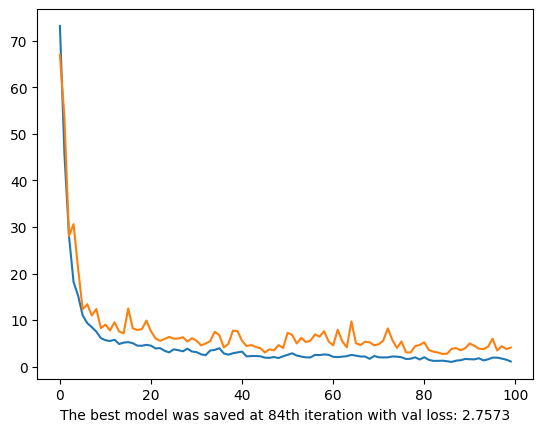

In [30]:
plt.plot(df.train_loss)
plt.plot(df.val_loss)
plt.xlabel(f"The best model was saved at {checkpoint['epoch']}th iteration with val loss: {checkpoint['loss']:.4f}")
plt.show()

In [195]:
from torchvision.models import resnet18

model = resnet18(weights=None).to(device)
model.fc = torch.nn.Linear(in_features=512, out_features=256, bias=True)

In [31]:
# model.load_state_dict(checkpoint['model'])

# Finding a threshold

In [41]:
embeddings = []

model.eval()
with torch.no_grad():
    for images, targets in tqdm.tqdm(testLoader):
        images = images.to(device)
        targets = targets.to(device)

        features, output = model(images)
        for vector in features:
            embeddings.append(vector.cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.97it/s]


In [45]:
embeddings[0].shape

(256,)

In [46]:
ddf = pd.DataFrame({
    "feature_vector": embeddings
})

In [47]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [48]:
columns = ["feature_"+str(i) for i in range(0, 256)]
ddf[columns] = pd.DataFrame(ddf['feature_vector'].tolist(), index=ddf.index)
ddf = ddf.drop(columns=['feature_vector'])
ddf = pd.concat([test, ddf], axis=1)
ddf.to_csv("test_feature_vectors_center_loss.csv", index=False)

In [49]:
ddf.head()

,id,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,Zac Efron_60.jpg,Zac Efron,-1.760520,-0.836008,0.798890,1.033375,0.623507,-1.186337,-1.185222,-0.197013,...,-0.918334,-0.381150,1.364439,0.671677,-1.062970,-0.009317,-0.584523,-1.448803,3.050221,-0.160683
1,Elizabeth Olsen_0.jpg,Elizabeth Olsen,0.024142,0.496284,-0.552204,0.339686,0.328761,-0.496818,-0.589094,-0.857496,...,0.992106,-0.886638,0.893636,-0.134451,0.823998,1.016782,-0.351759,0.494451,-0.593570,0.567497
2,Jessica Alba_22.jpg,Jessica Alba,-0.611679,0.558979,-1.450023,-0.440779,1.710741,-0.426802,-0.051814,-1.088931,...,1.454296,1.465587,-1.540708,-1.956587,0.237458,-0.007816,-0.230256,0.203086,-1.945978,0.286759
3,Dwayne Johnson_10.jpg,Dwayne Johnson,-0.137061,-1.442176,-1.916911,-0.588693,-0.062530,-0.830929,0.559717,-0.161158,...,1.616928,1.546604,0.630572,-0.454785,-0.587831,-0.578592,0.702713,1.662765,-0.689047,0.493829
4,Claire Holt_67.jpg,Claire Holt,0.749410,0.077539,-0.751555,-1.085508,0.084830,-0.865636,-1.138106,-0.536337,...,0.644378,0.971796,-1.949165,-0.683661,1.193235,0.046037,1.507033,-0.547462,0.765345,-1.470929


In [50]:
one_person = ddf[ddf.label == "Zac Efron"].copy()

In [51]:
first = one_person.values[0][2:]

In [52]:
positive_others = one_person.values[1:, 2:]

In [32]:
from sklearn.metrics.pairwise import cosine_similarity

In [55]:
cosine_similarity(first.reshape(1, -1), positive_others.reshape(-1, 256))

array([[0.99866015, 0.99978851, 0.99982803, 0.9998537 , 0.99989348,
        0.99979803, 0.99982762, 0.99981818, 0.99978413, 0.99985401,
        0.99983875, 0.99988396, 0.99986463, 0.99985521, 0.99984051,
        0.99984506, 0.99614951]])

In [56]:
negatives = ddf[ddf.label != "Zac Efron"].values[:, 2:]

In [58]:
cosine_similarity(first.reshape(1, -1), negatives.reshape(-1, 256))

array([[-0.02266313,  0.02458686, -0.01556354, -0.0457704 , -0.00687025,
         0.01595472,  0.03192335,  0.17980017,  0.07500997, -0.00950404,
        -0.0091045 , -0.0832809 , -0.01063441, -0.02552585, -0.01611585,
         0.01852232,  0.1420852 ,  0.01190297,  0.15782949,  0.11595422,
        -0.12327384, -0.13906215,  0.1141339 ,  0.09070609, -0.01291221,
        -0.04933495, -0.08914397,  0.00925448,  0.02110626, -0.01248182,
         0.0151052 ,  0.02266475,  0.1720904 ,  0.08876793,  0.00189687,
         0.11844033,  0.01616239, -0.00640404,  0.08582266,  0.02449106,
         0.00543939,  0.09174118,  0.08708162,  0.02146252,  0.02069314,
        -0.04993305, -0.017106  , -0.04286474,  0.08735907, -0.03944793,
        -0.04956991, -0.01165332,  0.07722386, -0.01802536, -0.06987893,
        -0.03918846, -0.01623817, -0.01630445,  0.0207619 , -0.02334572,
         0.11238541,  0.08863662, -0.01573365,  0.02154845,  0.01206415,
         0.11169584,  0.02059292, -0.04150871,  0.0

In [2]:
test_df = pd.read_csv("test_feature_vectors_center_loss.csv")

In [4]:
test_df.head()

,id,label,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255
0,Zac Efron_60.jpg,Zac Efron,-1.760520,-0.836008,0.798890,1.033375,0.623507,-1.186337,-1.185222,-0.197013,...,-0.918334,-0.381150,1.364439,0.671677,-1.062970,-0.009317,-0.584523,-1.448803,3.050221,-0.160683
1,Elizabeth Olsen_0.jpg,Elizabeth Olsen,0.024142,0.496284,-0.552204,0.339686,0.328761,-0.496818,-0.589094,-0.857496,...,0.992106,-0.886638,0.893636,-0.134451,0.823998,1.016782,-0.351759,0.494451,-0.593570,0.567497
2,Jessica Alba_22.jpg,Jessica Alba,-0.611680,0.558979,-1.450023,-0.440779,1.710741,-0.426802,-0.051814,-1.088931,...,1.454296,1.465587,-1.540708,-1.956587,0.237458,-0.007816,-0.230256,0.203086,-1.945978,0.286759
3,Dwayne Johnson_10.jpg,Dwayne Johnson,-0.137061,-1.442176,-1.916911,-0.588693,-0.062530,-0.830929,0.559717,-0.161158,...,1.616928,1.546604,0.630572,-0.454785,-0.587831,-0.578592,0.702713,1.662764,-0.689047,0.493829
4,Claire Holt_67.jpg,Claire Holt,0.749410,0.077539,-0.751555,-1.085508,0.084830,-0.865636,-1.138106,-0.536337,...,0.644378,0.971796,-1.949164,-0.683661,1.193235,0.046037,1.507033,-0.547462,0.765344,-1.470929


In [15]:
splitted_df = np.array_split(test_df, 4)

C:\Users\yerda\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [72]:
positives = test_df[test_df.label == identities[1]].values[:, 2:]

In [73]:
positives.shape

(14, 256)

In [76]:
(cosine_similarity(positives[0].reshape(-1, 256), positives[1:].reshape(-1, 256)) > 0.8).sum()

13

In [ ]:
positive_correct = [22]

In [86]:
positive_correct_all = []

for identity in identities:
    positives = test_df[test_df.label == identity].values[:, 2:]

    positive_correct = []

    for i, positive in enumerate(positives):
        positives = positives.reshape(-1, 256)
        sim = (cosine_similarity(positive.reshape(-1, 256), positives) > 0.8).sum()
        if sim != 1:
            positive_correct.append(sim / len(positives))
    positive_correct_all.append(np.mean(positive_correct))

In [91]:
negative_correct_all = []

for identity in tqdm.tqdm(identities):
    negatives = test_df[test_df.label != identity].values[:, 2:]

    negative_correct = []

    for i, negative in enumerate(negatives):
        negatives = negatives.reshape(-1, 256)
        sim = (cosine_similarity(negative.reshape(-1, 256), negatives) < 0.8).sum()
        if sim != 1:
            negative_correct.append(sim / len(negatives))
    negative_correct_all.append(np.mean(negative_correct))

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:46<00:00,  1.49s/it]


In [93]:
np.mean(negative_correct_all)

0.9639533685957761

In [95]:
print(f" Acc for positive examples: {np.mean(positive_correct_all)} | Acc for negative examples: {np.mean(negative_correct_all)} | when the threshold: 0.8")

 Acc for positive examples: 0.9499283792935422 | Acc for negative examples: 0.9639533685957761 | when the threshold: 0.8


In [97]:
positive_correct_all = []

for identity in tqdm.tqdm(identities):
    positives = test_df[test_df.label == identity].values[:, 2:]

    positive_correct = []

    for i, positive in enumerate(positives):
        positives = positives.reshape(-1, 256)
        sim = (cosine_similarity(positive.reshape(-1, 256), positives) > 0.9).sum()
        if sim != 1:
            positive_correct.append(sim / len(positives))
    positive_correct_all.append(np.mean(positive_correct))
    
negative_correct_all = []

for identity in tqdm.tqdm(identities):
    negatives = test_df[test_df.label != identity].values[:, 2:]

    negative_correct = []

    for i, negative in enumerate(negatives):
        negatives = negatives.reshape(-1, 256)
        sim = (cosine_similarity(negative.reshape(-1, 256), negatives) < 0.9).sum()
        if sim != 1:
            negative_correct.append(sim / len(negatives))
    negative_correct_all.append(np.mean(negative_correct))
print(f" Acc for positive examples: {np.mean(positive_correct_all)} | Acc for negative examples: {np.mean(negative_correct_all)} | when the threshold: 0.9")

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:47<00:00,  1.53s/it]

 Acc for positive examples: 0.9415977464506985 | Acc for negative examples: 0.9650904865144916 | when the threshold: 0.9


In [98]:
positive_correct_all = []

for identity in tqdm.tqdm(identities):
    positives = test_df[test_df.label == identity].values[:, 2:]

    positive_correct = []

    for i, positive in enumerate(positives):
        positives = positives.reshape(-1, 256)
        sim = (cosine_similarity(positive.reshape(-1, 256), positives) > 0.5).sum()
        if sim != 1:
            positive_correct.append(sim / len(positives))
    positive_correct_all.append(np.mean(positive_correct))
    
negative_correct_all = []

for identity in tqdm.tqdm(identities):
    negatives = test_df[test_df.label != identity].values[:, 2:]

    negative_correct = []

    for i, negative in enumerate(negatives):
        negatives = negatives.reshape(-1, 256)
        sim = (cosine_similarity(negative.reshape(-1, 256), negatives) < 0.5).sum()
        if sim != 1:
            negative_correct.append(sim / len(negatives))
    negative_correct_all.append(np.mean(negative_correct))
print(f" Acc for positive examples: {np.mean(positive_correct_all)} | Acc for negative examples: {np.mean(negative_correct_all)} | when the threshold: 0.5")

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:46<00:00,  1.51s/it]

 Acc for positive examples: 0.9689745533807508 | Acc for negative examples: 0.9613360257819165 | when the threshold: 0.5


In [99]:
positive_correct_all = []

for identity in tqdm.tqdm(identities):
    positives = test_df[test_df.label == identity].values[:, 2:]

    positive_correct = []

    for i, positive in enumerate(positives):
        positives = positives.reshape(-1, 256)
        sim = (cosine_similarity(positive.reshape(-1, 256), positives) > 0.1).sum()
        if sim != 1:
            positive_correct.append(sim / len(positives))
    positive_correct_all.append(np.mean(positive_correct))
    
negative_correct_all = []

for identity in tqdm.tqdm(identities):
    negatives = test_df[test_df.label != identity].values[:, 2:]

    negative_correct = []

    for i, negative in enumerate(negatives):
        negatives = negatives.reshape(-1, 256)
        sim = (cosine_similarity(negative.reshape(-1, 256), negatives) < 0.1).sum()
        if sim != 1:
            negative_correct.append(sim / len(negatives))
    negative_correct_all.append(np.mean(negative_correct))
print(f" Acc for positive examples: {np.mean(positive_correct_all)} | Acc for negative examples: {np.mean(negative_correct_all)} | when the threshold: 0.1")

100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:47<00:00,  1.53s/it]

 Acc for positive examples: 0.9956214815476723 | Acc for negative examples: 0.8896020558267141 | when the threshold: 0.1
